In [1]:
cd ..

/Users/casperneo/work/cloud-research/clouds


In [86]:
%load_ext autoreload
%autoreload 2
from reproduction.pipeline import load as pipeline
import os
import tensorflow as tf
import numpy as np
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder
from tensorflow.errors import InvalidArgumentError, OutOfRangeError
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
hdf_data = True

In [112]:
# data_dir = "/project/foster/clouds/nasa_laads/mod06_l2/order501256920/"
# meta_json = "jsons3/MOD06_L2.A2017001.1850.061.2017312170757.json"
# data_files = ["records3/MOD06_L2.A2017001.1850.061.2017312170757.tfrecord"]


if hdf_data:
    fields = ['Cloud_Optical_Thickness', 'Cloud_Effective_Radius', 'Cloud_Water_Path']
    data_dir = "experimental/test/"
    meta_json = "ex.json"
    data_files = ["ex.tfrecord"]
else:
    fields = ["b%d"%(i+1) for i in range(7)]
    data_dir = "data/tif/"
    meta_json = "2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.json"
    data_files = ["2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.tfrecord"]

shape = (64, 64)
batch_size = 32

meta_json = os.path.join(data_dir, meta_json)
data_files = [os.path.join(data_dir, f) for f in data_files]

In [113]:
def get_one_sample(f):
    data_files = [f]
    def not_all_same(x):
        return tf.reduce_any(tf.not_equal(x, x[0,0,0]))

    chans, parser = pipeline.main_parser(fields, meta_json)
    dataset = (
        tf.data.Dataset.from_tensor_slices(data_files)
    #     .apply(shuffle_and_repeat(100))
        .flat_map(tf.data.TFRecordDataset)
        .map(parser)
        .interleave(pipeline.patchify_fn(*shape[:2], chans), cycle_length=4)
        .filter(not_all_same)
    #     .shuffle(10000)
        .apply(batch_and_drop_remainder(batch_size))
    )

    x = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        y = sess.run(x)
    return y


In [114]:
g = get_one_sample(data_files[0])

### We should normalize the data by clipping negative values then dividing by maximum

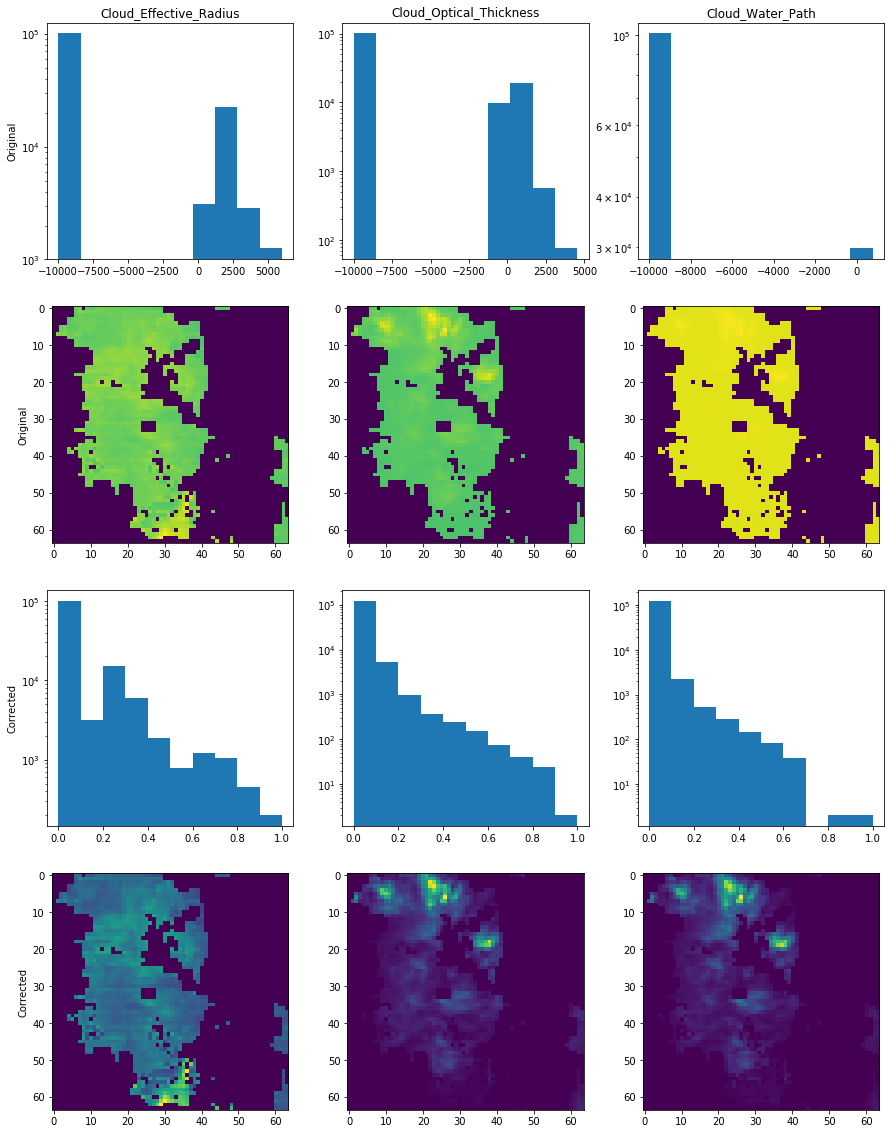

In [128]:
width = 5
fig, ax = plt.subplots(
    nrows=4,
    ncols=len(fields),
    figsize=(
        len(fields) * width,
        4 * width
    )
)

ex = 20

corrected = g.clip(0, 1e10)
corrected /= corrected.max(axis=(0,1,2))

# Original Distributiton
for i, f in enumerate(fields):
    a, b, c, d = ax[:, i]
    a.hist(g[:,:,:,i].ravel())
    a.set_yscale("log")
    a.set_title(f)

    b.imshow(g[ex,:,:,i])

    c.set_yscale("log")
    c.hist(corrected[:,:,:,i].ravel())

    d.imshow(corrected[ex,:,:,i])
    
    if not i:
        a.set_ylabel("Original")
        b.set_ylabel("Original")
        c.set_ylabel("Corrected")
        d.set_ylabel("Corrected")


In [105]:
empty = []
errs = []
iargs = []
samples = {}
for x in os.listdir(data_dir + "/records3"):
    x = os.path.join(data_dir , "records3", x)
    name = x.split("/")[-1].replace(".tfrecord", "")
    try:
        samples[x] = get_one_sample(x)
        print(name, "Is okay")
    except OutOfRangeError as e:
        print(name, "Has no clouds")
        empty.append(x)
    except InvalidArgumentError as e:
        print(name, "Can't be parsed")
        iargs.append(x)


FileNotFoundError: [Errno 2] No such file or directory: 'data/tif//records3'

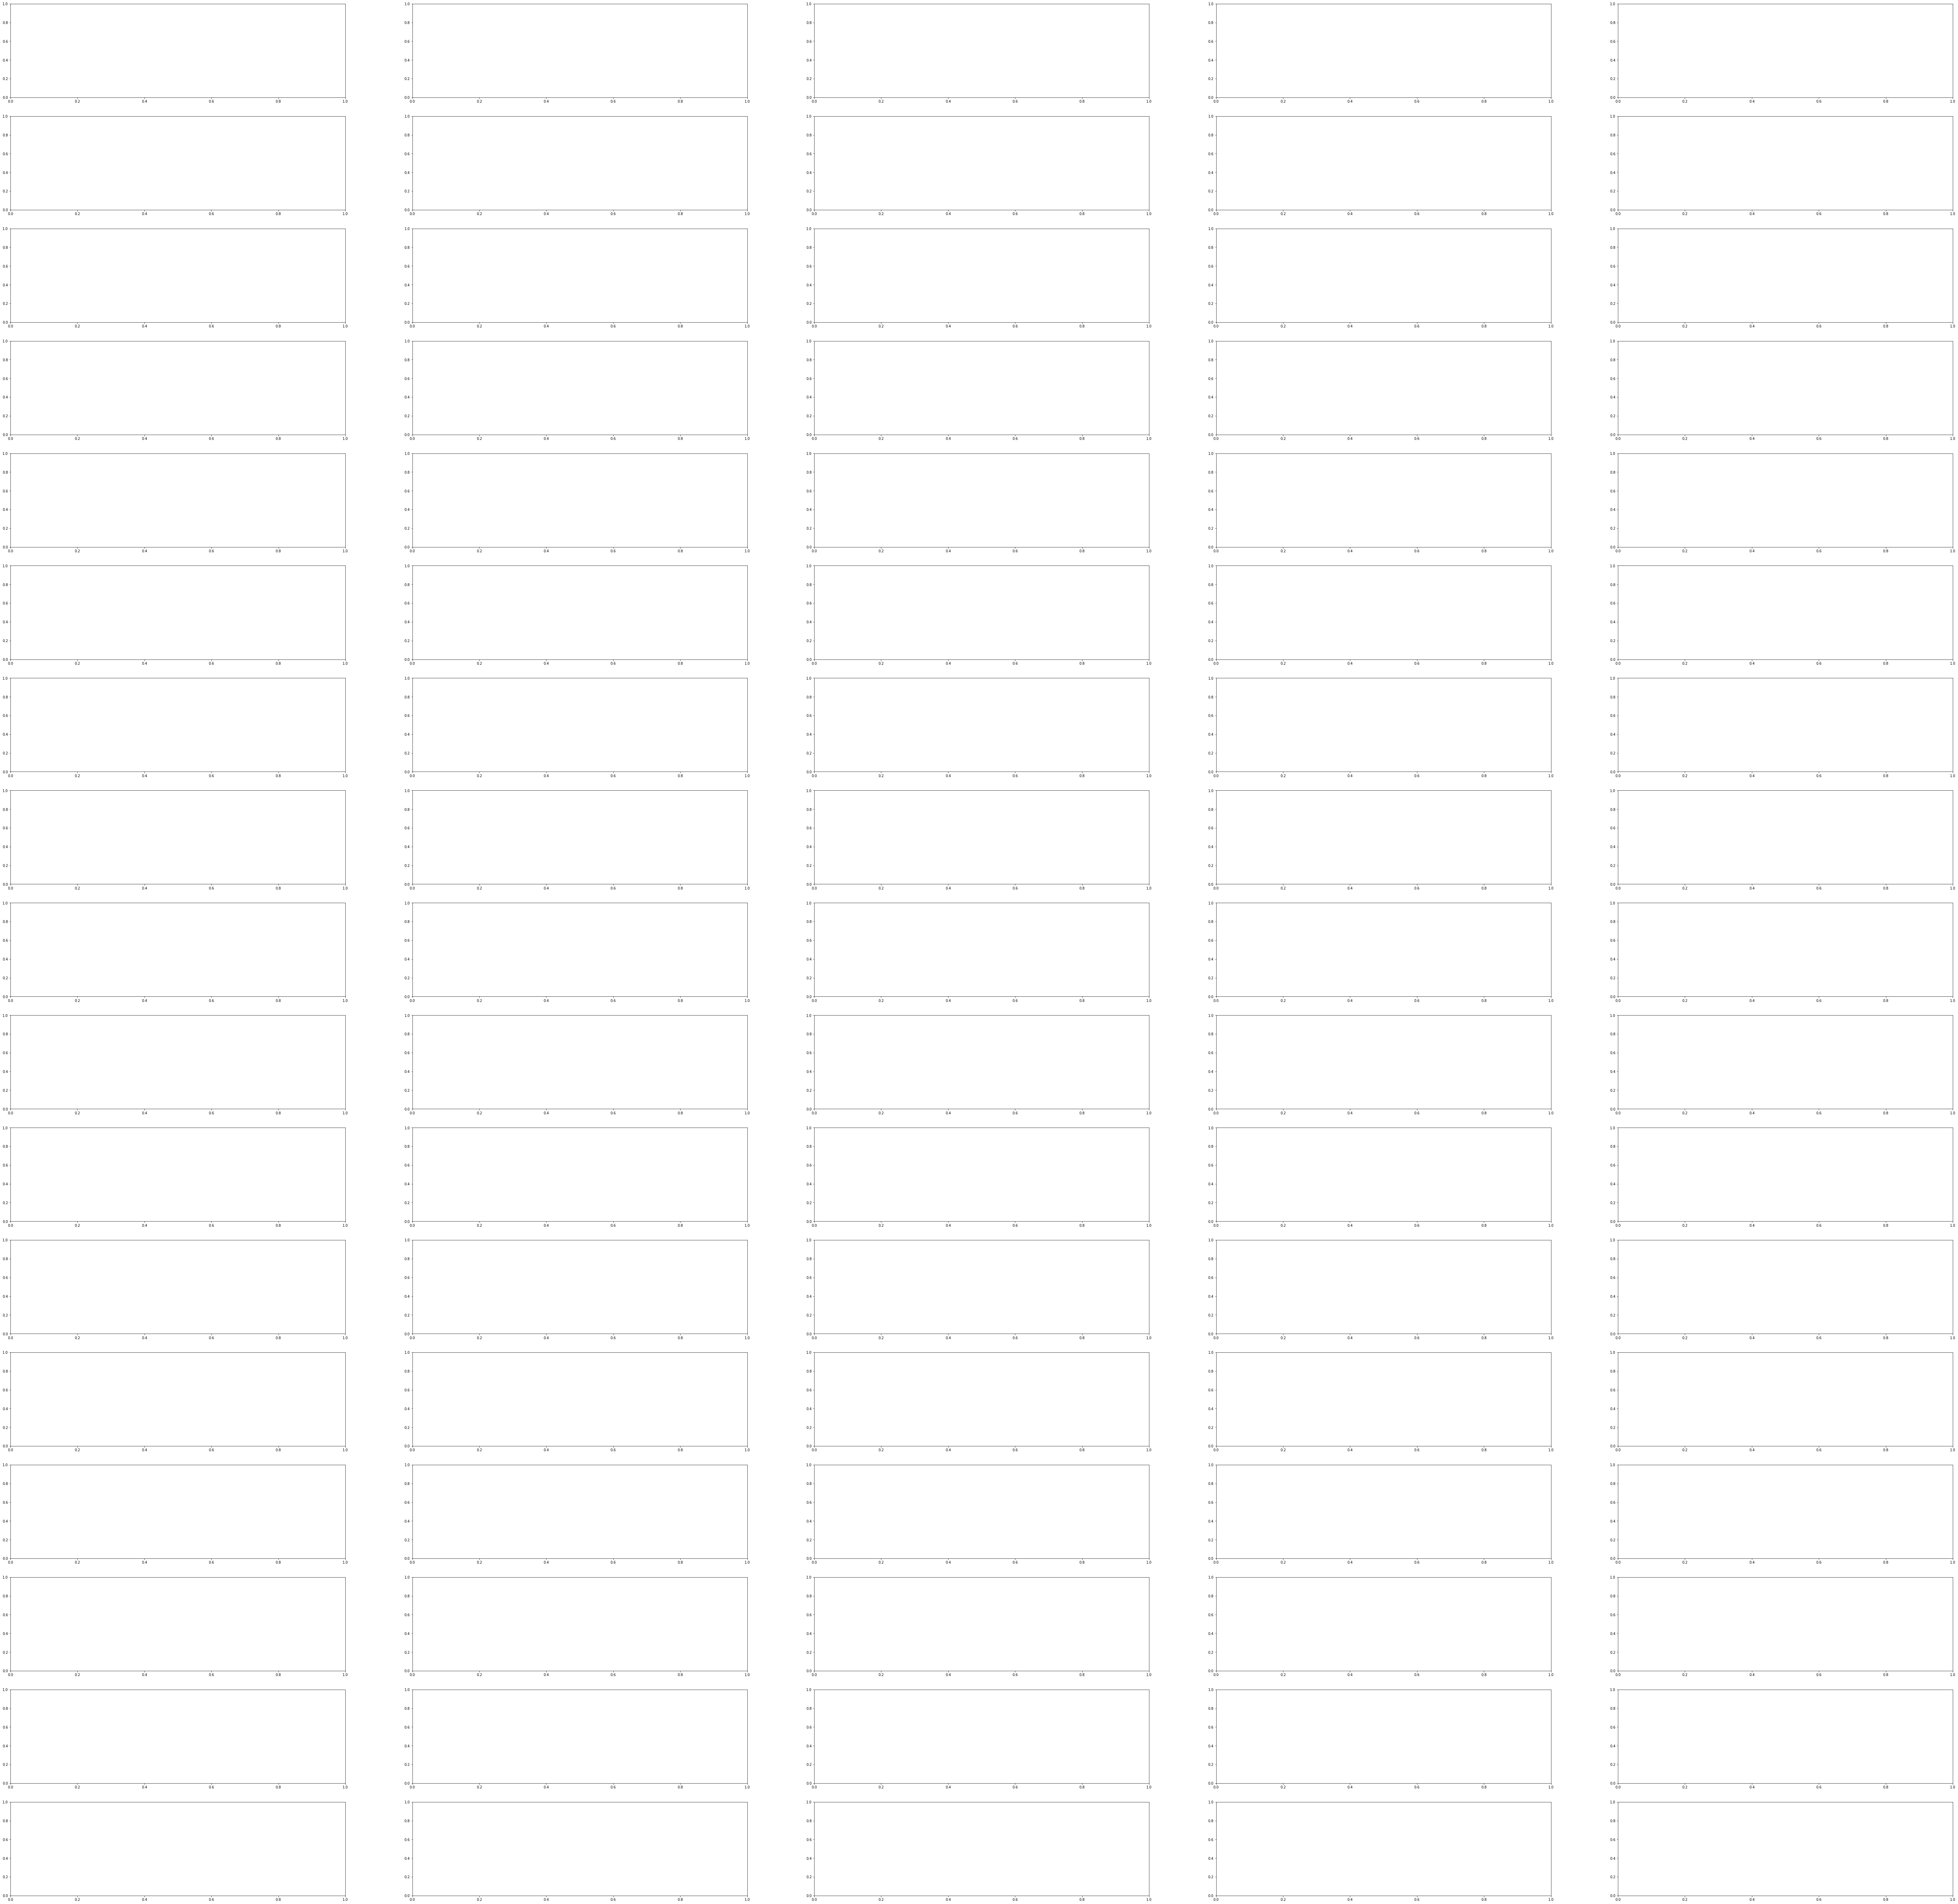

In [106]:
fig, ax = plt.subplots(nrows=17, ncols=5, figsize=(100, 100))

for i, k in enumerate(samples):
    for col in range(5):
        a = ax[i, col]
        if col == 0:
            name = x.split("/")[-1].replace(".tfrecord","")
            a.set_title(name)
        a.axis("off")
        a.imshow(samples[k][col,:,:,0])

fig.savefig("cloud-optical-thickness-hdf-samples.png")